In [3]:
from main import *

In [4]:
input_path = "data/VOC2012_test/JPEGImages/2008_000200.jpg"

# Felzenszwalb

In [5]:
sigma = 0.5
k = 500
min = 50

Height:  375
Width:   500
Execution time: 0 minute(s) and 15 seconds


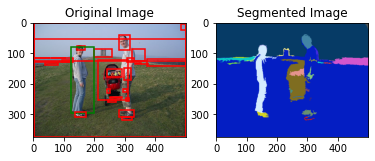

In [4]:
univ, bb = segment_felzenszwalb(input_path, sigma, 300, 50)

# Higra - watershed

Height:  375
Width:   500
Execution time: 0 minute(s) and 4 seconds
0 1 0.08184818835532026 0
0 2 0 0
0 3 0.6085106382978723 0
0 4 0.13754492673486315 0.6085106382978723
0 5 0.014604067503245348 0.6085106382978723
0 6 0.033802582949213074 0.6085106382978723
0 7 0 0.6085106382978723
0 8 0 0.6085106382978723
0 9 0 0.6085106382978723
0 10 0.14775777414075286 0.6085106382978723
1 1 0.10802353369841287 0
1 2 0.3482142857142857 0
1 3 0 0
1 4 0.11041420403830844 0
1 5 0 0
1 6 0 0
1 7 0.0773712621026476 0
1 8 0.38938492063492064 0
1 9 0.045871559633027525 0
1 10 0 0


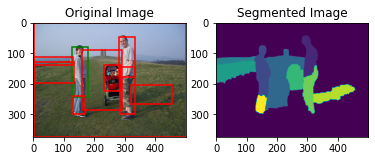

In [6]:
g, bb_water = segment_watershed(input_path)